In [54]:
#python basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os
import logging

#spacy stuff
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP
import en_core_web_sm

#gensim stuff
from gensim.models import CoherenceModel, LdaMulticore,LdaModel
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this

#custom dependencies
import PMC_module

#other
import warnings
import pickle
warnings.filterwarnings('ignore')

## Import Data

In [25]:
#Import Data
path = '~/Documents/NYU-MSDS/2021_police-misconduct/misclass/data/cpd'
narratives_path = os.path.join(path, "narratives.csv")
narratives = pd.read_csv(narratives_path)
intake = narratives.column_name.str.contains('take')
narratives = (narratives[intake])[["cr_id", "column_name", "text"]]
narratives = narratives.drop_duplicates()
df = narratives[:].copy()
df_list = df.text.values.tolist() #store documents as list of lists

## PreProcessing
### Input Normalization

In [26]:
input_list_normalization = PMC_module.input_normalization(texts = df_list)
df_list_normalized = input_list_normalization.normalization_lower().normalization_whitespace().strip_accents().texts

### Spacy Filtering and Lemmatization

In [27]:
#stream spacy docs into lemmatization functions
nlp = spacy.load('en_core_web_sm')

lemmatized_texts = []
for doc in nlp.pipe(df_list_normalized, batch_size=20):
    spacy_tokenizer_test = PMC_module.spacy_filters(doc = doc)
    lemmatized_doc = spacy_tokenizer_test.filter_length()\
                                .filter_stop()\
                                    .filter_punc()\
                                        .lemmatization()\
                                            .bag

    lemmatized_texts.append(lemmatized_doc)

### Pickle Full Lemmatized Texts Spacy Filtering and Lemmatization

In [32]:
#write tfidf to a pickle
outfile_X_lemmatized = open('bl_lemmatized_texts.pkl', 'wb') 
pickle.dump(lemmatized_texts, outfile_X_lemmatized)
outfile_X_lemmatized.close()

##Works
# with open('bl_lemmatized_texts.pkl', 'rb') as f:
#     mynewlist = pickle.load(f)
# len(mynewlist)

## Modeling
### Gensim Vectorizing

In [67]:
corpus, id2word = PMC_module.gensim_vectorizing(lemmatized_texts,lower=0, upper=1)

Percentage of Remaining Vocabulary After Filtering Extremes:  1.0


### Gensim LDA modeling - Hyper Parameter Tunning

#### Check Convergence for Chunksizes/passes/terations for reasonable Hyper Params

In [78]:
logging.basicConfig(filename='model_callbacks.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
convergence_logger = ConvergenceMetric(logger='shell')

In [82]:
num_topics = 20
chunksize = 1000
passes = 2
iterations = 100
eval_every = 1
callbacks = [convergence_logger]

lda_model = LdaModel(id2word=id2word, 
                         num_topics=num_topics,
                         corpus=corpus,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         callbacks= callbacks)

#### Number of Topics - Hyper Paramter Tuning

In [89]:
num_topics_list = list(range(2,22,2))
model_lists = []
coherence_list = []

chunksize = 1000
passes = 2
iterations = 100

for num_topics in num_topics_list:
    lda_model = LdaModel(id2word=id2word, 
                         num_topics=num_topics,
                         corpus=corpus,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes)
                             
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_texts, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    model_lists.append(lda_model)
    coherence_list.append(coherence_score)
    print("LDA model/coherence complete for num_topics = ",num_topics)

LDA model/coherence complete for num_topics =  2
LDA model/coherence complete for num_topics =  4
LDA model/coherence complete for num_topics =  6
LDA model/coherence complete for num_topics =  8
LDA model/coherence complete for num_topics =  10
LDA model/coherence complete for num_topics =  12
LDA model/coherence complete for num_topics =  14
LDA model/coherence complete for num_topics =  16
LDA model/coherence complete for num_topics =  18
LDA model/coherence complete for num_topics =  20


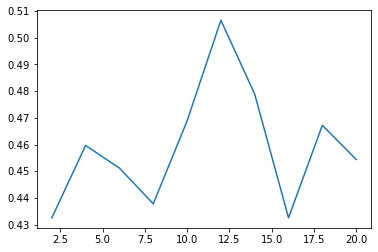

In [90]:
plt.plot(num_topics_list,coherence_list)

#### Topic Component Distribution

In [93]:
opt_topic_index = 5
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

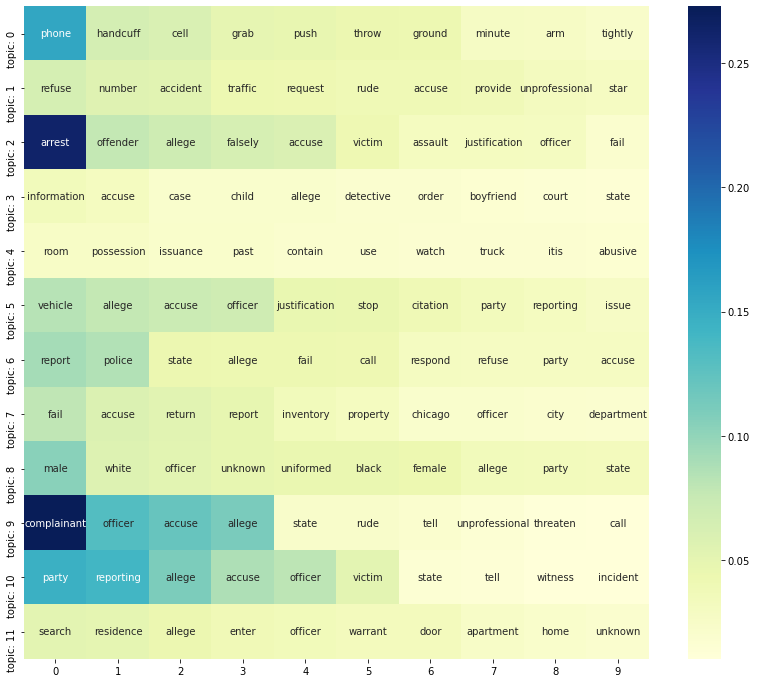

In [94]:
fig, ax = plt.subplots(1,1,figsize=(14,12))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")

#### pyLDAvis Principal Component Visualization

In [95]:
# Visualize the topics
visualization_name = 'lda_BL_12topics.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], corpus, id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

#### Most Represetative Documents


In [109]:
dom_topic_df = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],corpus, lemmatized_texts,df_list)
top_representatives = PMC_module.return_top_representatives(dom_topic_df, num_reps = 10)

In [110]:
topic_of_interest = 11
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives[top_representatives['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 11
---------
The complainant alleges that during the
execution of a search warrant, an unknown
officer(s) entered his home with a search
warrant while he was not home
and left his home in a disarray.
------
The complainant alleges that during the
execution of a search warrant, an unknown
officer(s) entered his home with a search
while he was not home
and left his home in a disarray.
------
The victim alleges that Police Officrs
entered his apartment without announcing
and knocking on the door before they
entered and executed a warrant. The
victim's friend was in the apartment and
witnessed the breaking of walls, damaging
the doors and ransacking of the apartment.
The victim's contents were stolen due to the
broken locks on his door by unknown
persons.
The victim alleges that Police Officrs
entered his apartment without announcing
and knocking on the door before they
entered and executed a warrant. The
victim's friend was in the apartment and
witnessed the breaking of walls, dama